## Loading data

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
def load_data(file_path):
    columns = ['Word', 'POS', 'Chunk', 'Tag']

    with open(file_path, 'r') as file:
        rows = []
        sentence_index = 1  # Start sentence indexing
        for line in file:
            if line.startswith('-DOCSTART-') or line.strip() == '':  # Skip doc starts and empty lines
                sentence_index += 1
                continue
            parts = line.strip().split()
            parts.append(sentence_index)  # Append the sentence index to each word entry
            rows.append(parts)

    data = pd.DataFrame(rows, columns=columns + ['Sentence #'])
    return data


In [82]:
train = load_data("../data/eng.train")
testa = load_data("../data/eng.testa")
testb = load_data("../data/eng.testb")

## Testing REGEXP performance for NER

In [83]:
import re
regex = r"[A-Z]+[^ ,.]*"

def regexp_pred(df):
    pred = [1 if re.search(regex,str(df['Word'][i])) else 0 for i in range(len(df))]
    return np.array(pred)

def true_labels(df):
    true = [1 if df['Tag'][i] == 'I-PER' else 0 for i in range(len(df))]
    return np.array(true)

In [84]:
train_pred = regexp_pred(train)
testa_pred = regexp_pred(testa)
testb_pred = regexp_pred(testb)

train_true = true_labels(train)
testa_true = true_labels(testa)
testb_true = true_labels(testb)

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculating accuracy
train_accuracy = accuracy_score(train_true, train_pred)
testa_accuracy = accuracy_score(testa_true, testa_pred)
testb_accuracy = accuracy_score(testb_true, testb_pred)

# Calculating precision
train_precision = precision_score(train_true, train_pred, average='binary')
testa_precision = precision_score(testa_true, testa_pred, average='binary')
testb_precision = precision_score(testb_true, testb_pred, average='binary')

# Calculating recall
train_recall = recall_score(train_true, train_pred, average='binary')
testa_recall = recall_score(testa_true, testa_pred, average='binary')
testb_recall = recall_score(testb_true, testb_pred, average='binary')

# Calculating F1 score
train_f1 = f1_score(train_true, train_pred, average='binary')
testa_f1 = f1_score(testa_true, testa_pred, average='binary')
testb_f1 = f1_score(testb_true, testb_pred, average='binary')

print("Training Set - Accuracy:", train_accuracy, "Precision:", train_precision, "Recall:", train_recall, "F1 Score:", train_f1)
print("Test Set A - Accuracy:", testa_accuracy, "Precision:", testa_precision, "Recall:", testa_recall, "F1 Score:", testa_f1)
print("Test Set B - Accuracy:", testb_accuracy, "Precision:", testb_precision, "Recall:", testb_recall, "F1 Score:", testb_f1)


Training Set - Accuracy: 0.8326007631825794 Precision: 0.24534120152631111 Recall: 0.9937994248741913 F1 Score: 0.39353070955803854
Test Set A - Accuracy: 0.8404992100754323 Precision: 0.27636013480982186 Recall: 0.9895204826929184 F1 Score: 0.43205340252948926
Test Set B - Accuracy: 0.822267686012706 Precision: 0.2509090909090909 Recall: 0.995311936530833 F1 Score: 0.40078414288825964


## Building our own text-to-vector-to-label algorithm

Text Preprocessing

In [86]:
def clean_word(word):
    word = word.lower()
    word = re.sub(r'\d+', '<num>', word) # Special token <num> for numbers
    word = re.sub(r'[^\w<>\s]', '', word)  # \w matches alphanumeric characters and underscore, \s with spaces

    return word

In [87]:
def clean_data(data):
    data_copy = data.copy()
    data_copy['Word'] = data_copy['Word'].apply(clean_word)
    data_copy = data_copy[data_copy['Word'].str.strip() != '']
    return data_copy 

In [88]:
clean_train = clean_data(train)
clean_testa = clean_data(testa)
clean_testb = clean_data(testb)

Vocabulary class, with special tokens for padding and out-of-vocabulary words

In [89]:
class Vocabulary:
    def __init__(self, data):
        self.words = ['<PAD>'] + ['<OOV>'] + sorted(set(data['Word']))
        self.word_to_index = {word: i for i, word in enumerate(self.words)}
        self.index_to_word = {i: word for i, word in enumerate(self.words)}

    def size(self):
        return len(self.words)

    def word_index(self, word):
        return self.word_to_index.get(word, 1) # Return 1 (index of <OOV>) if word outside vocabulary

    def index_word(self, index):
        return self.index_to_word.get(index, None)


Learning dense embedding vectors for words in the vocabulary

In [90]:
class Embeddings:
    def __init__(self, vocabulary, vector_size=50, window_size=2, learning_rate=1e-3, epochs=10):
        self.vocabulary = vocabulary
        self.vector_size = vector_size
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.vectors = np.random.randn(self.vocabulary.size(), vector_size) # Randomly initializing embedding vectors
        self.vectors[0] = np.array([0]*vector_size) # Padding token vector is set to 0, OOV token remains random

    def train(self, sentences):
        for epoch in range(self.epochs):
            print(f"Epoch {epoch} starting")
            for sentence in sentences:
                for i, token in enumerate(sentence):
                    current_idx = self.vocabulary.word_index(token)
                    start = max(0, i-self.window_size)
                    end = min(len(sentence), i+self.window_size+1)
                    for j in range(start, end):
                        if i!=j and sentence[j]:
                            context_idx = self.vocabulary.word_index(sentence[j])
                            self.update_vectors(current_idx,  context_idx)

    def update_vectors(self, current_idx, context_idx):
        current_vector = self.vectors[current_idx]
        context_vector = self.vectors[context_idx]
        grad = current_vector - context_vector
        self.vectors[current_idx] -= grad * self.learning_rate
        self.vectors[context_idx] += grad * self.learning_rate

    def word_to_embedding(self, word):
        idx = self.vocabulary.word_index(word)
        return self.vectors[idx]




Extracting sentences from the dataframe

In [91]:
def extract_sentences(df):
    sentences = df.groupby('Sentence #')['Word'].apply(list).tolist()
    return sentences

In [92]:
train_sentences = extract_sentences(clean_train)
testa_sentences = extract_sentences(clean_testa)
testb_sentences = extract_sentences(clean_testb)

print(max([len(sentence) for sentence in train_sentences]))
print(train_sentences[:10])

89
[['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb'], ['peter', 'blackburn'], ['brussels', '<num><num><num>'], ['the', 'european', 'commission', 'said', 'on', 'thursday', 'it', 'disagreed', 'with', 'german', 'advice', 'to', 'consumers', 'to', 'shun', 'british', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep'], ['germany', 's', 'representative', 'to', 'the', 'european', 'union', 's', 'veterinary', 'committee', 'werner', 'zwingmann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer'], ['we', 'do', 'nt', 'support', 'any', 'such', 'recommendation', 'because', 'we', 'do', 'nt', 'see', 'any', 'grounds', 'for', 'it', 'the', 'commission', 's', 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'a', 'news', 'briefing'], ['he', 'said', 'further', 'scientific', 'stu

In [93]:
def remove_empty_sentences(sentences):
    sentences = [sentence for sentence in sentences if len(sentence)>0]
    return sentences

def clean_sentences(sentences):
    sentences = remove_empty_sentences(sentences)
    return sentences

In [94]:
train_sentences = clean_sentences(train_sentences)
testa_sentences = clean_sentences(testa_sentences)
testb_sentences = clean_sentences(testb_sentences)

In [95]:
print(len(train_sentences))
print(np.sum([len(sentence) for sentence in train_sentences]))

97930
1244180


Vectorizing sentences

In [96]:
def sentence_to_vectors(sentence, embedding):
    return [embedding.word_to_embedding(word) for word in sentence]

In [97]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def pad_sentences(sentences, padding='post', maxlen=None):
    return pad_sequences(sentences, padding=padding, maxlen=maxlen)


In [98]:
vocab = Vocabulary(clean_train)
wordlist = list(vocab.index_to_word.values())
wordlist = [wordlist[i:i+50] for i in range(200, len(wordlist), 500)]
res = []
for L in wordlist:
    res += L
print(res)

['accomplice', 'accomplices', 'accomplish', 'accomplished', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'accosts', 'account', 'accountant', 'accounted', 'accounting', 'accounts', 'accreditation', 'accredited', 'acct', 'accumulated', 'accuracy', 'accurate', 'accurately', 'accusation', 'accusations', 'accuse', 'accused', 'accuses', 'accusing', 'aces', 'achieve', 'achieved', 'achievement', 'achievements', 'achieving', 'ackerman', 'acknowledge', 'acknowledged', 'acquire', 'acquired', 'acquiring', 'acquisition', 'acquisitions', 'acquittal', 'acquitted', 'acre', 'acreage', 'acres', 'acrimonious', 'acrobatic', 'across', 'andersson', 'anderton', 'andhra', 'andi', 'andre', 'andrea', 'andreas', 'andrei', 'andrejez', 'andres', 'andrew', 'andrews', 'andria', 'andrievskaqya', 'andruw', 'andy', 'angel', 'angeles', 'angelesbased', 'angeli', 'angelica', 'angelo', 'angels', 'anger', 'angered', 'anglert', 'angola', 'angolan', 'angry', 'anguish', 'anhui', 'anil', 'animal', 'animals', '

In [102]:
embeddings = Embeddings(vocab, learning_rate=1e-3)
embeddings.train(train_sentences)

Epoch 0 starting
Epoch 1 starting
Epoch 2 starting
Epoch 3 starting
Epoch 4 starting
Epoch 5 starting
Epoch 6 starting
Epoch 7 starting
Epoch 8 starting
Epoch 9 starting


In [100]:
words = ["accomplish", "achieve", "accusation", "acquittal", "accountant", "accounts", "angry", "happy", "acre", "kilometre", "animal", "human", "acquisition", "loss", "accredited", "accurate", "andrea", "andrew", "adventure", "routine"]

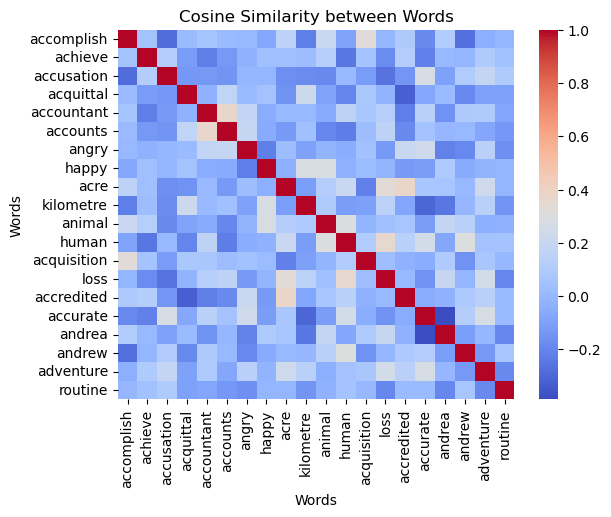

In [103]:
import seaborn as sns

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

similarity_matrix = np.zeros((len(words), len(words)))

for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        vec1 = embeddings.word_to_embedding(word1)
        vec2 = embeddings.word_to_embedding(word2)
        similarity_matrix[i, j] = cosine_similarity(vec1, vec2)

sns.heatmap(similarity_matrix, annot=False, fmt=".2f", cmap='coolwarm', xticklabels=words, yticklabels=words)
plt.title('Cosine Similarity between Words')
plt.xlabel('Words')
plt.ylabel('Words')
plt.show()


In [28]:
def embed_and_pad_sentences(sentences, max_length, embeddings):
    padded_sentences = []
    for sentence in sentences:
        embedded_sentence = [embeddings.word_to_embedding(word) for word in sentence]
        padding_length = max_length - len(embedded_sentence)
        padding = [np.zeros(embeddings.vector_size) for _ in range(padding_length)]
        embedded_sentence.extend(padding)
        padded_sentences.append(embedded_sentence)
    return np.array(padded_sentences)

In [109]:
max_length = max([len(sentence) for sentence in train_sentences])
train_sentences_embeddings = embed_and_pad_sentences(train_sentences, max_length, embeddings)
testa_sentences_embeddings = embed_and_pad_sentences(testa_sentences, max_length, embeddings)
testb_sentences_embeddings = embed_and_pad_sentences(testb_sentences, max_length, embeddings)

In [110]:
print(train_sentences_embeddings[0])

[[ 1.19631068e-02  5.22147491e-02  2.83654337e-03 ...  3.50313379e-02
   8.12866869e-03 -1.47267952e-02]
 [-5.25679071e-01  5.32444480e-01 -2.53130883e-01 ...  5.96071872e-01
   1.10261015e+00  5.38494850e-02]
 [ 1.88038202e-02 -9.02890489e-03  9.07736719e-03 ...  9.14509694e-03
  -7.03883025e-04 -1.53230539e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Preparing label sequences

In [111]:
def prepare_labels_from_df(df, padding_label=-1, maxlen=None):
    grouped = df.groupby('Sentence #')['Tag'].apply(list)

    if maxlen is None:
        maxlen = max(grouped.apply(len))

    label_sequences = []

    for tags in grouped:
        label_sequence = [1 if tag == 'I-PER' else 0 for tag in tags]
        label_sequence = label_sequence[:maxlen]
        label_sequence += [padding_label] * (maxlen - len(label_sequence))
        label_sequences.append(label_sequence)

    return np.array(label_sequences)


In [112]:
train_labels = prepare_labels_from_df(clean_train)
testa_labels = prepare_labels_from_df(clean_testa, maxlen=len(train_labels[0]))
testb_labels = prepare_labels_from_df(clean_testb, maxlen=len(train_labels[0]))

In [113]:
print(train_labels.shape)
print(train_sentences_embeddings.shape)

(97930, 89)
(97930, 89, 50)


In [104]:
print(train_sentences[4])

['germany', 's', 'representative', 'to', 'the', 'european', 'union', 's', 'veterinary', 'committee', 'werner', 'zwingmann', 'said', 'on', 'wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer']


In [114]:
print(train_labels[4])

[ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Building model architecture

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Input, Masking

def create_model(model_type='RNN'):
    model = Sequential()
    model.add(Input(shape=(max_length, embeddings.vectors.shape[1])))
    model.add(Masking(mask_value=0.0))

    if model_type == 'RNN':
        model.add(SimpleRNN(64, return_sequences=True))
    elif model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=True))
    elif model_type == 'GRU':
        model.add(GRU(64, return_sequences=True))

    model.add(Dense(1, activation='sigmoid'))

    return model

In order to mask padded values when calculating the loss function, we can use weight sampling

In [116]:
def generate_sample_weights(labels, pad_value=-1):
    # Generate weights: 0 for pad_value, 1 otherwise
    weights = np.where(labels == pad_value, 0, 1)
    return weights

In [117]:
weights_train = generate_sample_weights(train_labels)
weights_test = generate_sample_weights(testa_labels)
weights_validation = generate_sample_weights(testb_labels)

In [33]:
weights_train[4]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

Adjusting learning rate

In [34]:
def controlled_tweak_learning_rate(x_train, y_train, model_fn, model_type, weights_train, learning_rates, epochs_per_lr=1):
    losses = []
    lrs = []

    for lr in learning_rates:
        model = model_fn(model_type)  # Rebuild model to reset weights
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()])
        history = model.fit(x_train,y_train, sample_weight=weights_train, epochs=epochs_per_lr)

        # Append average loss over epochs for current learning rate
        avg_loss = np.mean(history.history['loss'])
        losses.append(avg_loss)
        lrs.append(lr)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.semilogx(lrs, losses)
    plt.xlabel("Learning Rate")
    plt.ylabel("Average Loss")
    plt.title("Learning Rate vs. Average Loss")
    plt.grid(True)
    plt.show()

    return losses

We can now start testing the performance of various recurrent neural network architectures, starting with simple RNNs

In [118]:
train_labels = np.expand_dims(train_labels, axis=-1)
weights_train = np.expand_dims(weights_train, axis=-1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.0830 - loss: 0.7007 - recall: 0.5048
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - binary_accuracy: 0.0647 - loss: 0.7124 - recall_1: 0.5415
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.0989 - loss: 0.6913 - recall_2: 0.4510
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.0895 - loss: 0.7022 - recall_3: 0.4780
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.0881 - loss: 0.6941 - recall_4: 0.3934
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.0867 - loss: 0.7006 - recall_5: 0.4826
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - binary_accuracy: 0.0977 - loss: 0.7002 - recall_6: 0.4776
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - binary_accuracy: 0.0795 - loss: 0.7022 - recall_7: 0.4678
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.0980 - loss: 0.6933 - recall_8: 0.3812
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - binary_accuracy: 0.0752 - loss: 0.7156 - recall_9: 0.5391
10

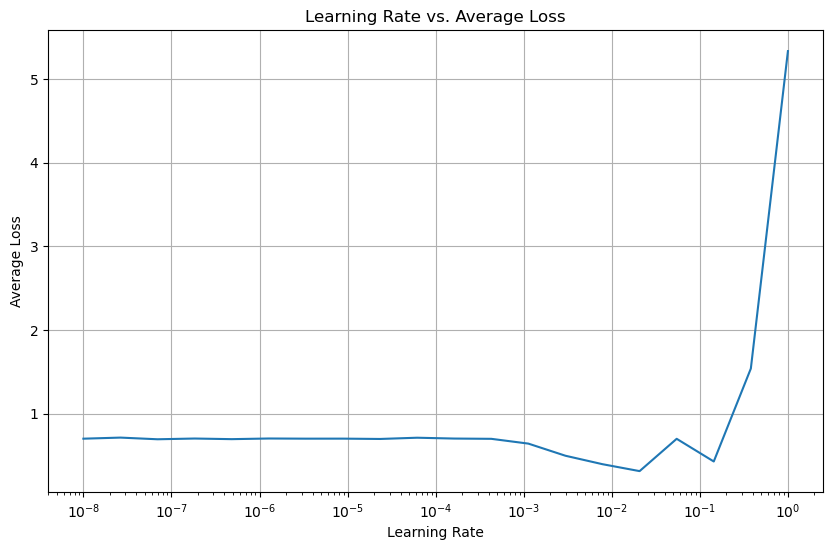

[0.6990346312522888,
 0.7120048999786377,
 0.6920188665390015,
 0.7008870244026184,
 0.6934316754341125,
 0.7012273669242859,
 0.6992489695549011,
 0.6996262669563293,
 0.6956729888916016,
 0.7105398774147034,
 0.700537383556366,
 0.6973263025283813,
 0.6401058435440063,
 0.4950259327888489,
 0.3938940763473511,
 0.3110848367214203,
 0.6975699067115784,
 0.42626580595970154,
 1.537776231765747,
 5.333993434906006]

In [36]:
reduced_train_set = train_sentences_embeddings[:300]
reduced_train_labels = train_labels[:300]
reduced_weights_train = weights_train[:300]

# We perform the learning rate test on the reduced dataset
controlled_tweak_learning_rate(reduced_train_set, reduced_train_labels, create_model, "RNN", reduced_weights_train, np.logspace(start=-8,stop=0,num=20,base=10))

Training the model

In [38]:
model = create_model("RNN")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_sentences_embeddings, train_labels, sample_weight=weights_train, epochs=10, batch_size=64)

Epoch 1/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.1333 - loss: 0.2778
Epoch 2/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.1345 - loss: 0.2013
Epoch 3/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1338 - loss: 0.1891
Epoch 4/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.1349 - loss: 0.1715
Epoch 5/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.1355 - loss: 0.1547
Epoch 6/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.1372 - loss: 0.1375
Epoch 7/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1371 - loss: 0.1257
Epoch 8/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.1375 - loss: 0.1131
Epoch 9/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.1374 - loss: 0.1044
Epoch 10/10
1531/1531 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.1386 - loss: 0.0966


In [39]:
testa_predictions = model.predict(np.array(testa_sentences_embeddings))

# Flatten the predictions and labels to make them easier to filter and evaluate
testa_predictions_flat = testa_predictions.flatten()
testa_labels_flat = np.array(testa_labels).flatten()

# Filter out the padding tokens (where labels are -1)
mask = testa_labels_flat != -1
filtered_predictions = testa_predictions_flat[mask]
filtered_labels = testa_labels_flat[mask]

# Since this is a classification task, convert probabilities to binary predictions
predicted_classes = (filtered_predictions > 0.5).astype(int)

# Sample output, replace this with your actual data and model for execution
print("Filtered Predictions:", predicted_classes)
print("Filtered True Labels:", filtered_labels)


710/710 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Filtered Predictions: [0 0 0 ... 0 0 0]
Filtered True Labels: [0 0 0 ... 0 0 0]


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(filtered_labels, predicted_classes)
precision = precision_score(filtered_labels, predicted_classes)
recall = recall_score(filtered_labels, predicted_classes)
f1 = f1_score(filtered_labels, predicted_classes)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9323142361720947
Precision: 0.5208413001912046
Recall: 0.4341727765380937
F1 Score: 0.47357440890125174


: 

Formalizing this process

In [119]:
def assess_performance(model_type):
    model = create_model(model_type)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_sentences_embeddings, train_labels, sample_weight=weights_train, epochs=10, batch_size=64, verbose=0)

    testa_predictions = model.predict(np.array(testa_sentences_embeddings))

    testa_predictions_flat = testa_predictions.flatten()
    testa_labels_flat = np.array(testa_labels).flatten()

    mask = testa_labels_flat != -1
    filtered_predictions = testa_predictions_flat[mask]
    filtered_labels = testa_labels_flat[mask]

    predicted_classes = (filtered_predictions > 0.5).astype(int)

    accuracy = accuracy_score(filtered_labels, predicted_classes)
    precision = precision_score(filtered_labels, predicted_classes)
    recall = recall_score(filtered_labels, predicted_classes)
    f1 = f1_score(filtered_labels, predicted_classes)

    print(f"For {model_type} recurrent layers, we obtain: ")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [120]:
assess_performance("RNN")

710/710 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
For RNN recurrent layers, we obtain: 
Accuracy: 0.9304589130552797
Precision: 0.5138592750533049
Recall: 0.15364998406120497
F1 Score: 0.2365644171779141


In [121]:
assess_performance("LSTM")

710/710 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
For LSTM recurrent layers, we obtain: 
Accuracy: 0.9358684093717767
Precision: 0.6459694989106753
Recall: 0.18903410902135798
F1 Score: 0.29247842170160293


In [122]:
assess_performance("GRU")

710/710 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
For GRU recurrent layers, we obtain: 
Accuracy: 0.9369637206094146
Precision: 0.6237314597970336
Recall: 0.25470194453299333
F1 Score: 0.3617021276595745


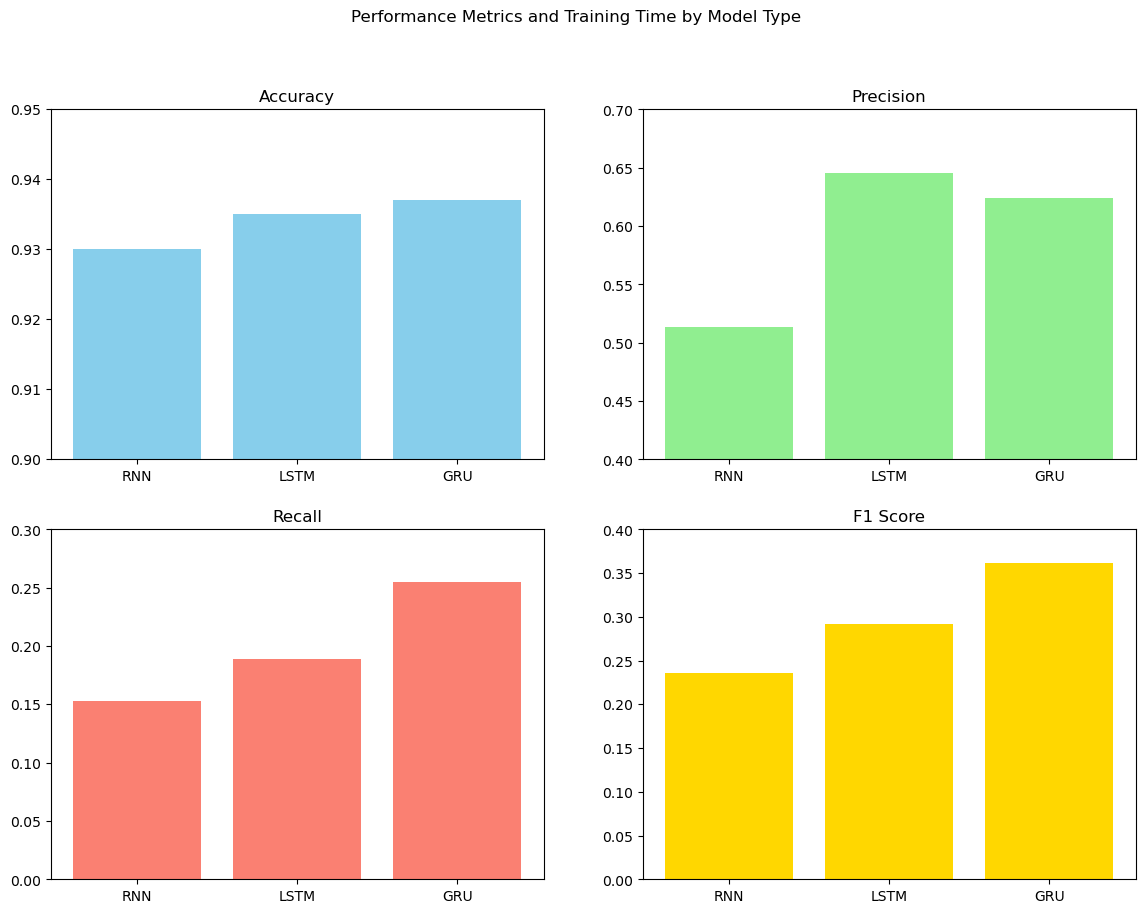

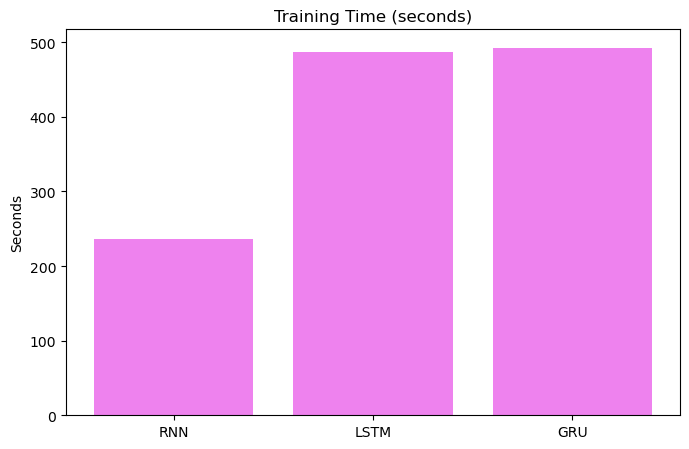

In [123]:
models = ['RNN', 'LSTM', 'GRU']
accuracy = [0.930, 0.935, 0.937]
precision = [0.513, 0.645, 0.624]
recall = [0.153, 0.189, 0.255]
f1_score = [0.236, 0.292, 0.362]
training_time = [3*60 + 56.2, 8*60 + 6.5, 8*60 + 12.7]  

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Metrics and Training Time by Model Type')

axs[0, 0].bar(models, accuracy, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim([0.9, 0.95])

axs[0, 1].bar(models, precision, color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylim([0.4, 0.7])

axs[1, 0].bar(models, recall, color='salmon')
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylim([0, 0.3])

axs[1, 1].bar(models, f1_score, color='gold')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_ylim([0, 0.4])

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(models, training_time, color='violet')
ax.set_title('Training Time (seconds)')
ax.set_ylabel('Seconds')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
